In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
%reload_ext autoreload
%autoreload 2
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import gc
import warnings
from pathlib import Path
from tqdm.notebook import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

import pytorch_lightning as pl

import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformers import AdamW, get_cosine_schedule_with_warmup

import optim
import loss
from utils import visualize, radar2precipitation, seed_everything

<IPython.core.display.Javascript object>

In [4]:
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

# 🔥 RainNet ⚡️

In [5]:
args = dict(
    seed=42,
    dams=(6071, 6304, 7026, 7629, 7767, 8944, 11107),
    train_folds_csv=Path("../input/train_folds.csv"),
    train_data_path=Path("../input/train"),
    test_data_path=Path("../input/test"),
    model_dir=Path("../models"),
    output_dir=Path("../output"),
    rng=255.0,
    num_workers=4,
    gpus=1,
    lr=1e-3,
    max_epochs=30,
    batch_size=128,
    precision=16,
    optimizer="adamw",
    scheduler="cosine",
    accumulate_grad_batches=1,
    gradient_clip_val=5.0,
    warmup_epochs=1,
)

args["trn_tfms"] = A.Compose(
    [
        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, p=1),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        # D_4 transformations
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Transpose(p=0.5),
        A.RandomRotate90(p=0.5),
        ToTensorV2(always_apply=True, p=1),
    ]
)

args["val_tfms"] = A.Compose(
    [
        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, p=1),
        ToTensorV2(always_apply=True, p=1),
    ]
)

<IPython.core.display.Javascript object>

## Dataset

In [6]:
class NowcastingDataset(Dataset):
    def __init__(self, paths, tfms=None, test=False):
        self.paths = paths
        if tfms is not None:
            self.tfms = tfms
        else:
            self.tfms = A.Compose(
                [
                    A.PadIfNeeded(
                        min_height=128, min_width=128, always_apply=True, p=1
                    ),
                    ToTensorV2(always_apply=True, p=1),
                ]
            )
        self.test = test

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = np.load(path)

        augmented = self.tfms(image=data)
        data = augmented["image"]

        x = data[:4, :, :]
        x = x / args["rng"]
        if self.test:
            return x
        else:
            y = data[4, :, :]
            y = y / args["rng"]
            y = y.unsqueeze(0)
            return x, y

<IPython.core.display.Javascript object>

In [7]:
class NowcastingDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df=None,
        val_df=None,
        batch_size=args["batch_size"],
        num_workers=args["num_workers"],
        test=False,
    ):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.test = test

    def setup(self, stage="train"):
        if stage == "train":
            train_paths = [
                args["train_data_path"] / fn for fn in self.train_df.filename.values
            ]
            val_paths = [
                args["train_data_path"] / fn for fn in self.val_df.filename.values
            ]
            self.train_dataset = NowcastingDataset(train_paths, tfms=args["trn_tfms"])
            self.val_dataset = NowcastingDataset(val_paths, tfms=args["val_tfms"])
        else:
            test_paths = list(sorted(args["test_data_path"].glob("*.npy")))
            self.test_dataset = NowcastingDataset(test_paths, test=True)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler=RandomSampler(self.train_dataset),
            pin_memory=True,
            num_workers=self.num_workers,
            drop_last=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=2 * self.batch_size,
            sampler=SequentialSampler(self.val_dataset),
            pin_memory=True,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=2 * self.batch_size,
            sampler=SequentialSampler(self.test_dataset),
            pin_memory=True,
            num_workers=self.num_workers,
        )

<IPython.core.display.Javascript object>

## RainNet

### Layers

In [8]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_ch),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        return self.net(x)


class Encoder(nn.Module):
    def __init__(self, chs=[4, 64, 128, 256, 512, 1024], drop_rate=0.5):
        super().__init__()
        self.blocks = nn.ModuleList(
            [Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)]
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #         self.dropout = nn.Dropout(p=drop_rate)

    def forward(self, x):
        feats = []
        for block in self.blocks:
            x = block(x)
            feats.append(x)
            x = self.pool(x)
        return feats


class Decoder(nn.Module):
    def __init__(self, chs=[1024, 512, 256, 128, 64], bilinear=True):
        super().__init__()
        if bilinear:
            self.upsamples = nn.ModuleList(
                [
                    nn.Upsample(scale_factor=2, mode="nearest")
                    for i in range(len(chs) - 1)
                ]
            )
        else:
            self.upsamples = nn.ModuleList(
                [
                    nn.ConvTranspose2d(chs[i], chs[i], kernel_size=2, stride=2)
                    for i in range(len(chs) - 1)
                ]
            )
        self.blocks = nn.ModuleList(
            [Block(chs[i] + chs[i + 1], chs[i + 1]) for i in range(len(chs) - 1)]
        )

    def forward(self, x, feats):
        for upsample, block, feat in zip(self.upsamples, self.blocks, feats):
            #             print("Before upsample:", x.shape)
            x = upsample(x)
            #             print("After upsample:", x.shape)
            #             print("Feat:", feat.shape)
            x = torch.cat([feat, x], dim=1)
            #             print("Concat:", x.shape)
            x = block(x)
        #             print("After block:", x.shape)
        return x

<IPython.core.display.Javascript object>

### RainNet

In [9]:
class RainNet(pl.LightningModule):
    def __init__(
        self,
        lr=args["lr"],
        enc_chs=[4, 64, 128, 256, 512, 1024],
        dec_chs=[1024, 512, 256, 128, 64],
        num_train_steps=None,
        bilinear=True,
    ):
        super().__init__()
        self.lr = lr
        self.num_train_steps = num_train_steps
        #         self.criterion = loss.LogCoshLoss()
        self.criterion = nn.L1Loss()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs, bilinear=bilinear)
        self.out = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(2),
            nn.Conv2d(2, 1, kernel_size=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        ftrs = self.encoder(x)
        ftrs = list(reversed(ftrs))
        x = self.decoder(ftrs[0], ftrs[1:])
        out = self.out(x)
        return out

    def shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss, y, y_hat

    def training_step(self, batch, batch_idx):
        loss, y, y_hat = self.shared_step(batch, batch_idx)
        self.log("train_loss", loss)
        for i, param_group in enumerate(self.optimizer.param_groups):
            self.log(f"lr/lr{i}", param_group["lr"])
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        loss, y, y_hat = self.shared_step(batch, batch_idx)
        return {"loss": loss, "y": y.detach(), "y_hat": y_hat.detach()}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("val_loss", avg_loss)

        y = torch.cat([x["y"] for x in outputs])
        y_hat = torch.cat([x["y_hat"] for x in outputs])

        crop = T.CenterCrop(120)
        y = crop(y)
        y_hat = crop(y_hat)

        batch_size = len(y)

        y = y.detach().cpu().numpy()
        y = y.reshape(batch_size, -1)
        y = y[:, args["dams"]]
        y *= args["rng"]

        y_hat = y_hat.detach().cpu().numpy()
        y_hat = y_hat.reshape(batch_size, -1)
        y_hat = y_hat[:, args["dams"]]
        y_hat *= args["rng"]

        y_true = radar2precipitation(y)
        y_true = np.nan_to_num(y_true)
        y_true = np.where(y_true >= 0.1, 1, 0)
        y_true = y_true.ravel()
        y_pred = radar2precipitation(y_hat)
        y_pred = np.nan_to_num(y_pred)
        y_pred = np.where(y_pred >= 0.1, 1, 0)
        y_pred = y_pred.ravel()

        y = y.ravel()
        y_hat = y_hat.ravel()
        #         mae = metrics.mean_absolute_error(y, y_hat, sample_weight=y_true)

        err = (y - y_hat) * y_true
        err = np.abs(err)
        mae = err.sum() / y_true.sum()
        self.log("mae", mae)

        tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
        csi = tp / (tp + fn + fp)
        self.log("csi", csi)

        comp_metric = mae / (csi + 1e-12)
        self.log("comp_metric", comp_metric)

        print(
            f"Epoch {self.current_epoch} | MAE/CSI: {comp_metric} | MAE: {mae} | CSI: {csi} | Loss: {avg_loss}"
        )

    def configure_optimizers(self):
        # optimizer
        if args["optimizer"] == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif args["optimizer"] == "adamw":
            self.optimizer = AdamW(self.parameters(), lr=self.lr)
        elif args["optimizer"] == "radam":
            self.optimizer = optim.RAdam(self.parameters(), lr=self.lr)
        elif args["optimizer"] == "ranger":
            self.optimizer = optim.RAdam(self.parameters(), lr=self.lr)
            self.optimizer = optim.Lookahead(self.optimizer)

        # scheduler
        if args["scheduler"] == "cosine":
            self.scheduler = get_cosine_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=self.num_train_steps * args["warmup_epochs"],
                num_training_steps=self.num_train_steps * args["max_epochs"],
            )
            return [self.optimizer], [{"scheduler": self.scheduler, "interval": "step"}]
        elif args["scheduler"] == "step":
            self.scheduler = torch.optim.lr_scheduler.StepLR(
                self.optimizer, step_size=10, gamma=0.5
            )
            return [self.optimizer], [
                {"scheduler": self.scheduler, "interval": "epoch"}
            ]
        elif args["scheduler"] == "plateau":
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, mode="min", factor=0.1, patience=3, verbose=True
            )
            return [self.optimizer], [
                {
                    "scheduler": self.scheduler,
                    "interval": "epoch",
                    "reduce_on_plateau": True,
                    "monitor": "comp_metric",
                }
            ]
        else:
            self.scheduler = None
            return [self.optimizer]

<IPython.core.display.Javascript object>

## Train

In [10]:
seed_everything(args["seed"])
pl.seed_everything(args["seed"])

42

<IPython.core.display.Javascript object>

In [11]:
df = pd.read_csv(args["train_folds_csv"])

<IPython.core.display.Javascript object>

In [12]:
def train_fold(df, fold, lr_find=False, bilinear=False):
    train_df = df[df.fold != fold]
    val_df = df[df.fold == fold]

    datamodule = NowcastingDataModule(train_df, val_df)
    datamodule.setup()

    num_train_steps = np.ceil(
        len(train_df) // args["batch_size"] / args["accumulate_grad_batches"]
    )
    model = RainNet(num_train_steps=num_train_steps, bilinear=bilinear)

    trainer = pl.Trainer(
        gpus=args["gpus"],
        max_epochs=args["max_epochs"],
        precision=args["precision"],
        progress_bar_refresh_rate=50,
        benchmark=True,
    )

    if lr_find:
        lr_finder = trainer.tuner.lr_find(model, datamodule=datamodule)
        fig = lr_finder.plot(suggest=True)
        fig.show()
        return

    print(f"Training fold {fold}...")
    trainer.fit(model, datamodule)

    checkpoint = (
        args["model_dir"]
        / f"rainnet_fold{fold}_bs{args['batch_size']}_epochs{args['max_epochs']}_lr{model.lr}_{args['optimizer']}_{args['scheduler']}.ckpt"
    )
    trainer.save_checkpoint(checkpoint)
    print("Model saved at", checkpoint)

    del model, trainer, datamodule
    gc.collect()
    torch.cuda.empty_cache()

<IPython.core.display.Javascript object>

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 18 M  
2 | decoder   | Decoder    | 12 M  
3 | out       | Sequential | 1 K   


Epoch 0 | MAE/CSI: 336.4057808053285 | MAE: 53.408172231985944 | CSI: 0.15876116071428573 | Loss: 0.598244309425354


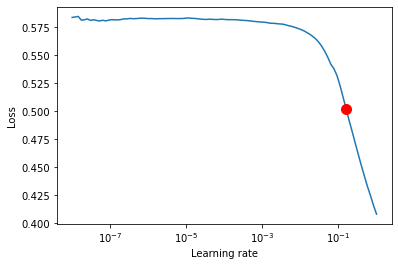

<IPython.core.display.Javascript object>

In [13]:
fold = 0
train_fold(df, fold, lr_find=True, bilinear=True)

In [13]:
# AdamW bs128 lr 1e-3
for fold in range(3, 5):
    train_fold(df, fold, bilinear=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


Training fold 3...



  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 18 M  
2 | decoder   | Decoder    | 12 M  
3 | out       | Sequential | 1 K   


Epoch 0 | MAE/CSI: 333.80968492449745 | MAE: 54.29995711835335 | CSI: 0.16266741071428573 | Loss: 0.5976119041442871


Epoch 0 | MAE/CSI: 897.4805797558428 | MAE: 131.8288601658786 | CSI: 0.14688770223957917 | Loss: 0.3941721022129059


Epoch 1 | MAE/CSI: 62.27968741500929 | MAE: 49.71846174715138 | CSI: 0.7983094297789787 | Loss: 0.10619045794010162


Epoch 2 | MAE/CSI: 51.03096083115544 | MAE: 41.170327154871714 | CSI: 0.8067715458276333 | Loss: 0.05389341711997986


Epoch 3 | MAE/CSI: 41.870023895369755 | MAE: 33.84436919860863 | CSI: 0.8083197965958048 | Loss: 0.03236943110823631


Epoch 4 | MAE/CSI: 58.09939029626976 | MAE: 44.26825712396326 | CSI: 0.7619401322142167 | Loss: 0.029098333790898323


Epoch 5 | MAE/CSI: 28.942792751517537 | MAE: 23.33243823304637 | CSI: 0.8061571125265393 | Loss: 0.02067316696047783


Epoch 6 | MAE/CSI: 53.99669242598665 | MAE: 43.353675534176126 | CSI: 0.8028950216450217 | Loss: 0.02821166254580021


Epoch 7 | MAE/CSI: 32.04677203726339 | MAE: 26.127100544228647 | CSI: 0.8152802570510532 | Loss: 0.018178801983594894


Epoch 8 | MAE/CSI: 28.976151397742242 | MAE: 22.920730599099635 | CSI: 0.7910205287254467 | Loss: 0.016079029068350792


Epoch 9 | MAE/CSI: 28.383541131706934 | MAE: 22.89738723793914 | CSI: 0.8067135503516276 | Loss: 0.015895841643214226


Epoch 10 | MAE/CSI: 20.95062814127194 | MAE: 17.168584835583847 | CSI: 0.8194782857961874 | Loss: 0.01434613298624754


Epoch 11 | MAE/CSI: 22.014546785850165 | MAE: 17.91003260661646 | CSI: 0.8135544547347261 | Loss: 0.0135035440325737


Epoch 12 | MAE/CSI: 24.204530623313506 | MAE: 19.835226456515226 | CSI: 0.8194840364880274 | Loss: 0.014604521915316582


Epoch 13 | MAE/CSI: 25.101654679531627 | MAE: 20.320823082193165 | CSI: 0.8095411773287621 | Loss: 0.013711189851164818


Epoch 14 | MAE/CSI: 42.288836897905085 | MAE: 34.155821396097565 | CSI: 0.8076793759666465 | Loss: 0.02133019082248211


Epoch 15 | MAE/CSI: 22.72397121966105 | MAE: 18.630803340553786 | CSI: 0.8198744471393922 | Loss: 0.013534926809370518


Epoch 16 | MAE/CSI: 19.38900916165812 | MAE: 15.965048825239066 | CSI: 0.8234071525836738 | Loss: 0.012179741635918617


Epoch 17 | MAE/CSI: 18.698915423727044 | MAE: 15.391048678889051 | CSI: 0.8230984701572936 | Loss: 0.01201721653342247


Epoch 18 | MAE/CSI: 16.95954925145322 | MAE: 14.02458430663457 | CSI: 0.8269432222920595 | Loss: 0.011911916546523571


Epoch 19 | MAE/CSI: 19.102043343973058 | MAE: 15.748123198514318 | CSI: 0.8244208703182507 | Loss: 0.01191040687263012


Epoch 20 | MAE/CSI: 18.597559459395143 | MAE: 15.368974849333386 | CSI: 0.8263974035340786 | Loss: 0.011771897785365582


Epoch 21 | MAE/CSI: 25.74025495893767 | MAE: 20.512034096336023 | CSI: 0.7968854282536151 | Loss: 0.013122732751071453


Epoch 22 | MAE/CSI: 17.44514014963167 | MAE: 14.439638433950963 | CSI: 0.8277169635830293 | Loss: 0.01137844193726778


Epoch 23 | MAE/CSI: 16.965247991466327 | MAE: 14.054709578584252 | CSI: 0.8284411513251638 | Loss: 0.011319248005747795


Epoch 24 | MAE/CSI: 17.071976303106727 | MAE: 14.176935324104486 | CSI: 0.8304214504742209 | Loss: 0.011334178037941456


Epoch 25 | MAE/CSI: 21.070881920526407 | MAE: 17.20383145260114 | CSI: 0.8164741996784096 | Loss: 0.011910214088857174


Epoch 26 | MAE/CSI: 17.567114500905664 | MAE: 14.552616832293463 | CSI: 0.8284010917971556 | Loss: 0.011215428821742535


Epoch 27 | MAE/CSI: 17.700134819210568 | MAE: 14.673700057502016 | CSI: 0.8290162875798235 | Loss: nan


Epoch 28 | MAE/CSI: 16.861073711530242 | MAE: 13.974469385870796 | CSI: 0.828800681672939 | Loss: 0.011209064163267612


Epoch 29 | MAE/CSI: 16.55801056230667 | MAE: 13.770253907006966 | CSI: 0.8316369804919423 | Loss: 0.011198918335139751


Epoch 30 | MAE/CSI: 17.554147940608242 | MAE: 14.57878300910975 | CSI: 0.8305035971223022 | Loss: 0.01112564280629158


Epoch 31 | MAE/CSI: 16.76119304453743 | MAE: 13.923268532773319 | CSI: 0.830684814366137 | Loss: 0.01107036042958498


Epoch 32 | MAE/CSI: 19.441490798446665 | MAE: 16.0359403762362 | CSI: 0.8248307983407321 | Loss: 0.011467971839010715


Epoch 33 | MAE/CSI: 17.355587980940548 | MAE: 14.433448203672098 | CSI: 0.8316311852704258 | Loss: 0.011089776642620564


Epoch 34 | MAE/CSI: 17.02594046602344 | MAE: 14.154698371813284 | CSI: 0.8313607345240657 | Loss: nan


Epoch 35 | MAE/CSI: 17.226843934596403 | MAE: 14.298206541355466 | CSI: 0.8299957087684166 | Loss: 0.0111991660669446


Epoch 36 | MAE/CSI: 17.52558967565483 | MAE: 14.524073421654798 | CSI: 0.8287352203511287 | Loss: nan


Epoch 37 | MAE/CSI: 17.000664120976474 | MAE: 14.145906853311773 | CSI: 0.8320796618668959 | Loss: nan


Epoch 38 | MAE/CSI: 17.192119008340825 | MAE: 14.279470621878838 | CSI: 0.8305823508395855 | Loss: 0.011099769733846188


Epoch 39 | MAE/CSI: 17.501530923501996 | MAE: 14.561604987631545 | CSI: 0.832018927444795 | Loss: 0.011133229359984398


Epoch 40 | MAE/CSI: 17.11781088939785 | MAE: 14.260544843964222 | CSI: 0.8330822753030629 | Loss: 0.011027307249605656


Epoch 41 | MAE/CSI: 17.127717819124367 | MAE: 14.273918239971103 | CSI: 0.8333812122953175 | Loss: nan


Epoch 42 | MAE/CSI: 17.297240984585702 | MAE: 14.392816391446573 | CSI: 0.8320874065554916 | Loss: 0.011013896204531193


Epoch 43 | MAE/CSI: 17.06983667119561 | MAE: 14.223638139651843 | CSI: 0.8332615252046531 | Loss: 0.011017526499927044


Epoch 44 | MAE/CSI: 16.874258566400567 | MAE: 14.063494046652337 | CSI: 0.8334288580025792 | Loss: 0.010977048426866531


Epoch 45 | MAE/CSI: 17.06194626092035 | MAE: 14.216245986705474 | CSI: 0.8332136187329406 | Loss: 0.010965126566588879


Epoch 46 | MAE/CSI: 17.032836104470533 | MAE: 14.191177015701529 | CSI: 0.8331658291457287 | Loss: nan


Epoch 47 | MAE/CSI: 17.062287420397098 | MAE: 14.212851090649654 | CSI: 0.8329979879275654 | Loss: nan


Epoch 48 | MAE/CSI: 16.98662652728378 | MAE: 14.14739142136189 | CSI: 0.832854681217691 | Loss: 0.01098165474832058


Epoch 49 | MAE/CSI: nan | MAE: nan | CSI: 0.0 | Loss: nan

Model saved at ../models/rainnet_fold3_bs128_epochs50_lr0.001_adamw_cosine.ckpt


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 18 M  
2 | decoder   | Decoder    | 12 M  
3 | out       | Sequential | 1 K   


Training fold 4...


Epoch 0 | MAE/CSI: 338.90126554727925 | MAE: 46.42871690427699 | CSI: 0.13699776785714285 | Loss: 0.5702202320098877


Epoch 0 | MAE/CSI: 806.1821516506415 | MAE: 116.39886444286728 | CSI: 0.14438283482676564 | Loss: 0.3368981182575226


Epoch 1 | MAE/CSI: 75.16980476926146 | MAE: 59.60485482710354 | CSI: 0.7929361398501605 | Loss: 0.10089846700429916


Epoch 2 | MAE/CSI: 42.92895430019841 | MAE: 34.3356556437781 | CSI: 0.7998251111273045 | Loss: 0.049018267542123795


Epoch 3 | MAE/CSI: 71.63203566769064 | MAE: 45.56232611165326 | CSI: 0.6360607469394081 | Loss: 0.04078567028045654


Epoch 4 | MAE/CSI: 38.77612885301583 | MAE: 29.132613082872506 | CSI: 0.7513027716939809 | Loss: 0.03022659197449684


Epoch 5 | MAE/CSI: 21.739253159306163 | MAE: 17.359716769921537 | CSI: 0.7985424633811964 | Loss: 0.025826146826148033


Epoch 6 | MAE/CSI: 54.782496479007904 | MAE: 37.67591465039355 | CSI: 0.6877363587250135 | Loss: 0.030195163562893867


Epoch 7 | MAE/CSI: 742.8501517640237 | MAE: 60.079657810398594 | CSI: 0.08087722357865365 | Loss: 0.3531918227672577


Epoch 8 | MAE/CSI: 24.702206443095875 | MAE: 17.36035949451936 | CSI: 0.7027857829010566 | Loss: nan


Epoch 9 | MAE/CSI: 22.227536442210173 | MAE: 17.81275771361929 | CSI: 0.8013824545922494 | Loss: 0.02086516283452511


Epoch 10 | MAE/CSI: 22.29764471751142 | MAE: 17.912670151441503 | CSI: 0.8033435987681479 | Loss: 0.021157000213861465


Epoch 11 | MAE/CSI: 20.449581123292713 | MAE: 16.55583820594202 | CSI: 0.809593023255814 | Loss: 0.020521478727459908


Epoch 12 | MAE/CSI: 20.33166529161092 | MAE: 16.50393622610229 | CSI: 0.8117355853232382 | Loss: 0.020242270082235336


Epoch 13 | MAE/CSI: 20.683163971062488 | MAE: 16.789809646407903 | CSI: 0.8117621496342435 | Loss: 0.02035018801689148


Epoch 14 | MAE/CSI: 20.66193309086924 | MAE: 16.791603210511788 | CSI: 0.8126830697129467 | Loss: 0.020121797919273376


Epoch 15 | MAE/CSI: 21.093142956439163 | MAE: 17.213118037631503 | CSI: 0.8160527842227379 | Loss: 0.02038026787340641


Epoch 16 | MAE/CSI: 20.201343842237886 | MAE: 16.473300550894148 | CSI: 0.8154556785688101 | Loss: 0.019691189751029015


Epoch 17 | MAE/CSI: 19.73730300231235 | MAE: 16.126644616134158 | CSI: 0.8170642470364408 | Loss: 0.019564786925911903


Epoch 18 | MAE/CSI: 19.450925229527122 | MAE: 15.888988732219955 | CSI: 0.8168757292882147 | Loss: 0.019540753215551376


Epoch 19 | MAE/CSI: 19.994974805097044 | MAE: 16.346886969263196 | CSI: 0.8175497658079626 | Loss: 0.01952250488102436


Epoch 20 | MAE/CSI: 19.392247995483242 | MAE: 15.827609635331957 | CSI: 0.8161823033100166 | Loss: 0.019708728417754173


Epoch 21 | MAE/CSI: 18.84369352128611 | MAE: 15.436225282855425 | CSI: 0.8191719561454126 | Loss: 0.019507233053445816


Epoch 22 | MAE/CSI: 18.33656521114948 | MAE: 15.086963344020766 | CSI: 0.8227802301179535 | Loss: 0.019308827817440033


Epoch 23 | MAE/CSI: 18.54581485978523 | MAE: 15.242784319479714 | CSI: 0.8218988723172063 | Loss: 0.019216997548937798


Epoch 24 | MAE/CSI: 19.448664960959523 | MAE: 15.984544189539761 | CSI: 0.8218838784876521 | Loss: 0.019489193335175514


Epoch 25 | MAE/CSI: 20.82109384534368 | MAE: 17.03837720216538 | CSI: 0.8183228666420391 | Loss: 0.01958519220352173


Epoch 26 | MAE/CSI: 20.24054374727606 | MAE: 16.643843877711287 | CSI: 0.8223022111217219 | Loss: 0.01959409937262535


Epoch 27 | MAE/CSI: 17.924900053519416 | MAE: 14.790640355773402 | CSI: 0.8251449275362319 | Loss: 0.019068608060479164


Epoch 28 | MAE/CSI: 18.718851155837456 | MAE: 15.398650177269081 | CSI: 0.8226279513125092 | Loss: 0.019055655226111412


Epoch 29 | MAE/CSI: 18.40323948183435 | MAE: 15.18014187403314 | CSI: 0.8248624862486249 | Loss: 0.01895592361688614


Epoch 30 | MAE/CSI: 19.002164368936324 | MAE: 15.706233083332256 | CSI: 0.8265496907809579 | Loss: 0.019661296159029007


Epoch 31 | MAE/CSI: 18.58631310867422 | MAE: 15.32234857187842 | CSI: 0.8243888113941708 | Loss: 0.01900278776884079


Epoch 32 | MAE/CSI: 19.440180543728903 | MAE: 16.02683319363738 | CSI: 0.8244179192455054 | Loss: 0.01921977289021015


Epoch 33 | MAE/CSI: 17.614090866057403 | MAE: 14.538675450064126 | CSI: 0.8254002753024705 | Loss: 0.018897555768489838


Epoch 34 | MAE/CSI: 18.152132127344974 | MAE: 15.032027843274696 | CSI: 0.8281136198106337 | Loss: 0.01902359165251255


Epoch 35 | MAE/CSI: 17.542260559925417 | MAE: 14.514299415412099 | CSI: 0.8273904817348275 | Loss: 0.018816150724887848


Epoch 36 | MAE/CSI: 18.44387790712202 | MAE: 15.212704829599623 | CSI: 0.824810536384372 | Loss: 0.018833208829164505


Epoch 37 | MAE/CSI: 18.880385944872334 | MAE: 15.58988389922997 | CSI: 0.8257184966838614 | Loss: 0.01897866278886795


Epoch 38 | MAE/CSI: 17.335944924174974 | MAE: 14.376118651174162 | CSI: 0.8292665161337315 | Loss: 0.01874425821006298


Epoch 39 | MAE/CSI: 18.805056933682675 | MAE: 15.533948506196678 | CSI: 0.8260516605166052 | Loss: 0.01892590895295143


Epoch 40 | MAE/CSI: 18.03388010130306 | MAE: 14.928971638260988 | CSI: 0.8278291501541172 | Loss: 0.018797585740685463


Epoch 41 | MAE/CSI: 18.358543678944105 | MAE: 15.17405025643718 | CSI: 0.8265388868411353 | Loss: 0.018825002014636993


Epoch 42 | MAE/CSI: 17.562529623285464 | MAE: 14.538143206992629 | CSI: 0.8277932347342217 | Loss: 0.01870065927505493


Epoch 43 | MAE/CSI: 17.33044092724963 | MAE: 14.352363408942034 | CSI: 0.8281591604722344 | Loss: 0.01869901828467846


Epoch 44 | MAE/CSI: 17.521509646326507 | MAE: 14.51028047646928 | CSI: 0.8281409975135293 | Loss: 0.018701208755373955


Epoch 45 | MAE/CSI: 17.35676461850729 | MAE: 14.377193026470843 | CSI: 0.8283336982701992 | Loss: 0.018678318709135056


Epoch 46 | MAE/CSI: 17.53255086591298 | MAE: 14.525100344015723 | CSI: 0.828464748517461 | Loss: 0.018688634037971497


Epoch 47 | MAE/CSI: 17.296111729836213 | MAE: 14.332469855655152 | CSI: 0.8286527098986067 | Loss: 0.018678631633520126


Epoch 48 | MAE/CSI: 17.387355794255527 | MAE: 14.396187441082615 | CSI: 0.8279687614042771 | Loss: 0.0186760313808918


Epoch 49 | MAE/CSI: 17.38408451568597 | MAE: 14.407766647946524 | CSI: 0.82879064669346 | Loss: 0.018671253696084023

Model saved at ../models/rainnet_fold4_bs128_epochs50_lr0.001_adamw_cosine.ckpt


<IPython.core.display.Javascript object>

## Inference

In [20]:
def inference(checkpoints):
    datamodule = NowcastingDataModule()
    datamodule.setup("test")

    final_preds = np.zeros((len(datamodule.test_dataset), 14400))

    for checkpoint in checkpoints:
        print(f"Inference from {checkpoint}")
        model = RainNet.load_from_checkpoint(str(checkpoint))
        model.cuda()
        model.eval()
        preds = []
        with torch.no_grad():
            for batch in tqdm(datamodule.test_dataloader()):
                batch = batch.cuda()
                imgs = model(batch)
                imgs = imgs.detach().cpu().numpy()
                imgs = imgs[:, 0, 4:124, 4:124]
                imgs = args["rng"] * imgs
                imgs = imgs.round()
                preds.append(imgs)

        preds = np.concatenate(preds)
        preds = preds.astype(np.uint8)
        preds = preds.reshape(-1, 14400)
        final_preds += preds / len(checkpoints)

        del model
        gc.collect()
        torch.cuda.empty_cache()

    final_preds = final_preds.round()
    final_preds = final_preds.astype(np.uint8)

    subm = pd.DataFrame()
    test_paths = datamodule.test_dataset.paths
    test_filenames = [path.name for path in test_paths]
    subm["file_name"] = test_filenames
    for i in tqdm(range(14400)):
        subm[str(i)] = final_preds[:, i]

    return subm

<IPython.core.display.Javascript object>

In [ ]:
def inference(checkpoints):
    datamodule = NowcastingDataModule()
    datamodule.setup("test")

    final_preds = np.zeros((len(datamodule.test_dataset), 14400))

    crop = T.CenterCrop(120)

    for checkpoint in checkpoints:
        print("Inference from", checkpoint)
        model = Baseline.load_from_checkpoint(str(checkpoint))
        model.cuda()
        model.eval()
        preds = []
        with torch.no_grad():
            for batch in tqdm(datamodule.test_dataloader()):
                batch = batch.cuda()
                imgs = model(batch)
                imgs = crop(imgs)
                imgs = imgs.detach().cpu().numpy()
                imgs = args["rng"] * imgs
                preds.append(imgs)

        preds = np.concatenate(preds)
        preds = preds.reshape(-1, 14400)
        final_preds += preds / len(checkpoints)

        del model
        gc.collect()
        torch.cuda.empty_cache()

    final_preds = final_preds.round()
    final_preds = final_preds.astype(np.uint8)

    subm = pd.DataFrame()
    test_paths = datamodule.test_dataset.paths
    test_filenames = [path.name for path in test_paths]
    subm["file_name"] = test_filenames
    for i in tqdm(range(14400)):
        subm[str(i)] = final_preds[:, i]

    return subm


def inference_tta(checkpoints):
    datamodule = NowcastingDataModule()
    datamodule.setup("test")

    final_preds = np.zeros((len(datamodule.test_dataset), 14400))

    crop = T.CenterCrop(120)

    for checkpoint in checkpoints:
        print("Inference from", checkpoint)
        model = Baseline.load_from_checkpoint(str(checkpoint))
        tta_model = ttach.SegmentationTTAWrapper(
            model, ttach.aliases.d4_transform(), merge_mode="mean"
        )
        tta_model.cuda()
        tta_model.eval()
        preds = []
        with torch.no_grad():
            for batch in tqdm(datamodule.test_dataloader()):
                batch = batch.cuda()
                imgs = model(batch)
                imgs = crop(imgs)
                imgs = imgs.detach().cpu().numpy()
                imgs = args["rng"] * imgs
                preds.append(imgs)

        preds = np.concatenate(preds)
        preds = preds.reshape(-1, 14400)
        final_preds += preds / len(checkpoints)

        del model
        gc.collect()
        torch.cuda.empty_cache()

    final_preds = final_preds.round()
    final_preds = final_preds.astype(np.uint8)

    test_paths = datamodule.test_dataset.paths
    test_filenames = [path.name for path in test_paths]

    subm = pd.DataFrame()
    subm["file_name"] = test_filenames
    for i in tqdm(range(14400)):
        subm[str(i)] = final_preds[:, i]

    return subm

In [21]:
checkpoints = [
    args["model_dir"]
    / f"rainnet_fold{fold}_bs{args['batch_size']}_epochs{args['max_epochs']}_lr{args['lr']}_{args['optimizer']}_{args['scheduler']}.ckpt"
    for fold in range(5)
]
subm = inference(checkpoints)

Inference from ../models/rainnet_fold0_bs128_epochs50_lr0.001_adamw_cosine.ckpt



Inference from ../models/rainnet_fold1_bs128_epochs50_lr0.001_adamw_cosine.ckpt



Inference from ../models/rainnet_fold2_bs128_epochs50_lr0.001_adamw_cosine.ckpt



Inference from ../models/rainnet_fold3_bs128_epochs50_lr0.001_adamw_cosine.ckpt



Inference from ../models/rainnet_fold4_bs128_epochs50_lr0.001_adamw_cosine.ckpt


<IPython.core.display.Javascript object>

In [22]:
output_path = (
    args["output_dir"]
    / f"rainnet_bs{args['batch_size']}_epochs{args['max_epochs']}_lr{args['lr']}_{args['optimizer']}_{args['scheduler']}.csv"
)
subm.to_csv(output_path, index=False)
subm.head()

,file_name,0,1,2,3,4,5,6,7,8,...,14390,14391,14392,14393,14394,14395,14396,14397,14398,14399
0,test_00000.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,test_00001.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,test_00002.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,test_00003.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,test_00004.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>